# Experiment for comparing topic modeling performance

## TODO:
- Set up hyperparameter tuning and compare performance
- Use more metrics

In [1]:
import json
import csv
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from octis.dataset.dataset import Dataset
from octis.models.model import AbstractModel
from octis.models.LDA import LDA
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from octis.evaluation_metrics.coherence_metrics import Coherence

from experiments.utils import Top2Vec


## Define Python classes and functions

In [2]:
class BERTopic_octis(AbstractModel):
    def train_model(self, dataset, hyperparams={}, top_words=10):
        # Setting hyperparameters
        if "umap_args" in hyperparams:
            umap_model = UMAP(**hyperparams["umap_args"])
        else:
            umap_model = UMAP(
                n_neighbors=30, 
                n_components=2,
                min_dist=0.0,
                metric='cosine',
                random_state=1
        )
        if "hdbscan_args" in hyperparams:
            hdbscan_model = HDBSCAN(**hyperparams["hdbscan_args"])
        else:
            hdbscan_model = HDBSCAN(
                min_cluster_size=50, 
                metric='euclidean',
                prediction_data=True
            )
        if "vectorizer_args" in hyperparams:
            vectorizer_model = CountVectorizer(**hyperparams["vectorizer_args"])
            n_gram_range = hyperparams["vectorizer_args"].get(['ngram_range'], (1,1))
        else:
            vectorizer_model = CountVectorizer(
                ngram_range=(1, 1),
                stop_words="english"
            )
            n_gram_range = (1, 1)
        
        model = BERTopic(
            n_gram_range=n_gram_range,
            top_n_words=top_words,  # defines number of words per topic
            nr_topics=20,
            low_memory=True,
            embedding_model="sentence-transformers/msmarco-distilbert-base-v4",
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model
        )
        
        # Train the BERTopic model
        doc_topics, _ = model.fit_transform(list(map(lambda x: " ".join(x), dataset.get_corpus())))

        result = {
            'topics': [[word[0] for word in values] for _, values in model.topics.items()],
            'topic-word-matrix': model.c_tf_idf,
            'topic-document-matrix': np.array(doc_topics),  # in BERTopic a document only belongs to a topic
            'test-topic-document-matrix': None
            }
        return result


class Top2Vec_octis(AbstractModel):
    def train_model(self, dataset, hyperparams={}, top_words=10):
        # Train the Top2Vec model
        model = Top2Vec(
            documents=list(map(lambda x: " ".join(x), dataset.get_corpus())), 
            **hyperparams
            )

        # Reduce the number of topics discovered by Top2Vec
        model.hierarchical_topic_reduction(20)
        model.get_topic_hierarchy()

        result = {
            'topics': [words[:10].tolist() for words in model.get_topics(20, reduced=True)[0]],
            'topic-word-matrix': np.inner(model.topic_vectors_reduced, model._get_word_vectors()),
            'topic-document-matrix': model.doc_top_reduced,  # in Top2Vec a document only belongs to a topic
            'test-topic-document-matrix': None
            }
        return result

def topic_evaluation(model_output, texts):
    """
    Provide a topic model output and get the score on several metrics.
    """
    output = {}

    # Topic Diversity
    metric = TopicDiversity(topk=10)
    output['topic_diversity'] = metric.score(model_output)

    # Topic Coherence
    metric = Coherence(texts=texts, topk=10, measure='c_v')
    output['topic_coherence'] = metric.score(model_output)

    return output

## Create the necessary data files

In [3]:
# Create the files for OCTIS
if not os.path.exists("../../data/experiments/corpus.tsv"):
    # Open json backup file
    with open("../../data/backups/mongodb_cleaned_docs.json", "r") as file:
        jsondata = json.load(file)
        jsondata = jsondata[:10000]  # TODO: REMOVE THIS WHEN DOING THE REAL EVALUATION

    # Remove #SEPTAG# and get categ
    text = list(map(lambda x: x['text'].replace("#SEPTAG#", " "), jsondata))
    categ = list(map(lambda x: x['meta']['category'], jsondata))

    # Write vocabulary file
    with open("../../data/experiments/vocabulary.txt", "w", newline='') as file:
        vectorizer = CountVectorizer(
            ngram_range=(1, 1),
            stop_words="english"
        )
        vectorizer.fit(text)
        for i in vectorizer.vocabulary_.keys():
            file.writelines(i+'\n')

    # Write corpus file
    with open("../../data/experiments/corpus.tsv", "w", newline='') as file:
        csv_writer = csv.writer(file, delimiter="\t")
        for text, categ in zip(text, categ):
            csv_writer.writerow([text, "train", categ])

## OCTIS : Optimizing and Comparing Topic Models is Simple!

### Loading the dataset

In [4]:
# Loading the dataset
dataset = Dataset()
dataset.load_custom_dataset_from_folder("../../data/experiments/")
docs = list(map(lambda x: " ".join(x), dataset.get_corpus()))

### Topic Model Evaluation
We compare different topic models according to different metrics provided by the OCTIS package.

The models we compare are: LDA, Top2Vec and BERTopic

In [5]:
# Save topic model scores
topic_scores = {}

# Save document topics
doc_topics = {}

#### LDA

In [6]:
# Perform LDA
model = LDA(num_topics=20, random_state=2)  # Create model
model_output = model.train_model(dataset) # Train the model

# Save topic scores
topic_scores['LDA'] = topic_evaluation(model_output, dataset.get_corpus())

# Save document topics
doc_topics['LDA'] = np.argmax(model_output['topic-document-matrix'], axis=0)

#### BERTopic

In [7]:
# Preprocess the docs to match the topic words (necessary to evaluate Coherence)
prep = CountVectorizer(
    lowercase=True
).build_preprocessor()
prep_docs = list(map(lambda x: prep(x).split(" "), docs))

In [8]:
# Perform BERTopic
model = BERTopic_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 50, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save topic scores
topic_scores['BERTopic'] = topic_evaluation(model_output, prep_docs)

# Save document topics
doc_topics['BERTopic'] = model_output['topic-document-matrix']

In [9]:
# What is the percentage of documents classified as noise?
perc_noise = 100 * (np.sum(doc_topics['BERTopic'] == -1) / doc_topics['BERTopic'].shape[0])
print(f"HDBSCAN classified {perc_noise}% of the observations as noise!")

HDBSCAN classified 21.77% of the observations as noise!


#### Top2Vec with Doc2Vec

In [11]:
# Perform BERTopic
model = Top2Vec_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "embedding_model": "doc2vec",
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 50, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save topic scores
topic_scores['Top2Vec_doc2vec'] = topic_evaluation(model_output, prep_docs)

# Save document topics
doc_topics['Top2Vec_doc2vec'] = model_output['topic-document-matrix']

2021-09-10 23:27:34,778 - top2vec - INFO - Pre-processing documents for training
2021-09-10 23:27:34,778 - top2vec - INFO - Pre-processing documents for training
2021-09-10 23:27:36,270 - top2vec - INFO - Creating joint document/word embedding
2021-09-10 23:27:36,270 - top2vec - INFO - Creating joint document/word embedding
2021-09-10 23:28:02,407 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-10 23:28:02,407 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-10 23:28:28,622 - top2vec - INFO - Finding dense areas of documents
2021-09-10 23:28:28,622 - top2vec - INFO - Finding dense areas of documents
2021-09-10 23:28:28,999 - top2vec - INFO - Finding topics
2021-09-10 23:28:28,999 - top2vec - INFO - Finding topics


#### Top2Vec with SBERT

In [12]:
# Perform BERTopic
model = Top2Vec_octis()  # Create model
model_output = model.train_model(
    dataset, 
    hyperparams={
        "embedding_model": "sentence-transformers/msmarco-distilbert-base-v4",
        "umap_args": {
            "n_neighbors": 30, 
            "n_components": 10, 
            "min_dist": 0.0, 
            "metric": 'cosine', 
            "random_state":1
        },
        "hdbscan_args": {
            "min_cluster_size": 50, 
            "min_samples": 15,
            "cluster_selection_epsilon": 0.2,
            "metric": 'euclidean',
            "prediction_data": True
        }
    }
) # Train the model

# Save topic scores
topic_scores['Top2Vec_sbert'] = topic_evaluation(model_output, prep_docs)

# Save document topics
doc_topics['Top2Vec_sbert'] = model_output['topic-document-matrix']

2021-09-10 23:28:30,565 - top2vec - INFO - Pre-processing documents for training
2021-09-10 23:28:30,565 - top2vec - INFO - Pre-processing documents for training
2021-09-10 23:28:32,282 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-09-10 23:28:32,282 - top2vec - INFO - Downloading sentence-transformers/msmarco-distilbert-base-v4 model
2021-09-10 23:28:34,054 - top2vec - INFO - Creating joint document/word embedding
2021-09-10 23:28:34,054 - top2vec - INFO - Creating joint document/word embedding
2021-09-10 23:28:59,320 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-10 23:28:59,320 - top2vec - INFO - Creating lower dimension embedding of documents
2021-09-10 23:29:24,867 - top2vec - INFO - Finding dense areas of documents
2021-09-10 23:29:24,867 - top2vec - INFO - Finding dense areas of documents
2021-09-10 23:29:25,230 - top2vec - INFO - Finding topics
2021-09-10 23:29:25,230 - top2vec - INFO - Finding topics


## Results

### Topic Modeling Metrics

In [13]:
tm_metrics = pd.DataFrame(
    data=[i[1] for i in topic_scores.items()], 
    index=[i[0] for i in topic_scores.items()]
)

# Display results
tm_metrics

,topic_diversity,topic_coherence
LDA,0.480000,0.369881
BERTopic,0.942857,0.546019
Top2Vec_doc2vec,0.920000,0.621779
Top2Vec_sbert,0.770000,0.404843


### UMAP Visualization

In [14]:
# Initialize UMAP
umap_model = UMAP(
    n_neighbors=30, 
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=1
)

# Get SBERT embeddings
embeddings = SentenceTransformer('sentence-transformers/msmarco-distilbert-base-v4').encode(docs, show_progress_bar=True)

# Reduce dimensionality
umap_emb = umap_model.fit_transform(embeddings)

Batches: 100%|██████████| 313/313 [00:31<00:00,  9.93it/s]


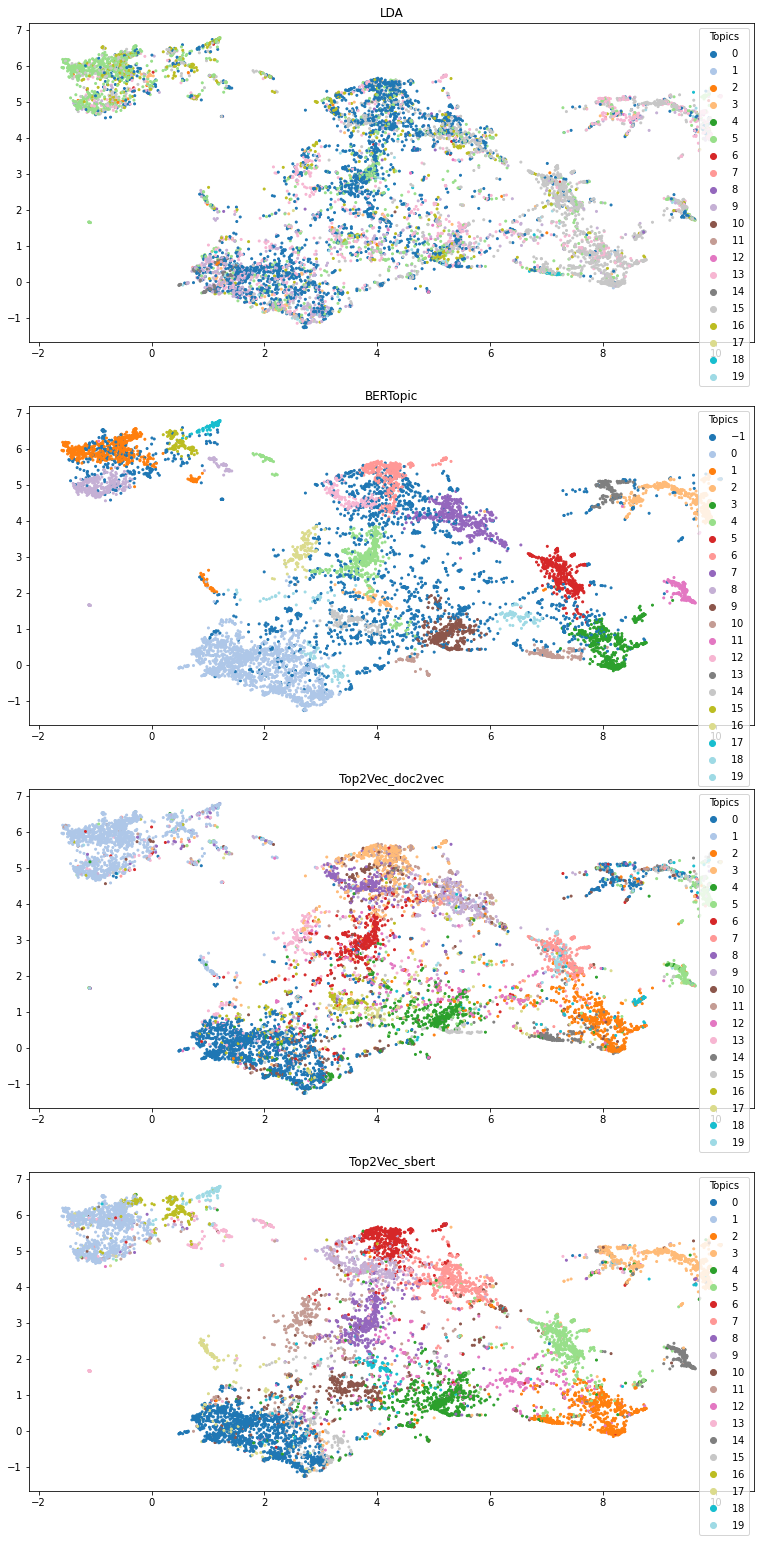

In [17]:
# Plot the 2D UMAP projection with the topic labels
fig, axes = plt.subplots(4, 1, figsize=(13, 27))
for ax, tm in zip(axes.flatten(), [i[0] for i in topic_scores.items()]):
    ax.set_title(tm)
    scatter = ax.scatter(umap_emb[:, 0], umap_emb[:, 1], s=4, c=doc_topics[tm], cmap='tab20')
    ax.legend(*scatter.legend_elements(num=20), loc="upper right", title="Topics")

fig.show()

## Saving results to disk

In [18]:
# Save results to disk
tm_metrics.to_csv("../../outputs/topic_comparison.csv", index_label="Model")

# Save figure
fig.savefig("../../outputs/umap_topics.png")